In [1]:
from NHITS import NHITS_CLOVER
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from helper_functions import evaluation
import seaborn as sns
from hierarchicalforecast.utils import HierarchicalPlot
sns.set_theme('notebook', 'white')
from torch.distributions import LowRankMultivariateNormal
import torch
import os
df = pd.read_parquet('loans_full_hierarchy.parquet')
df['date'] = df.index
df_nodate = df.reset_index(drop = True)
from PIL import Image

/home/jovyan/.conda/envs/GPU/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-12 13:18:02,955	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-06-12 13:18:03,923	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


# Evaluate reconciliation method 

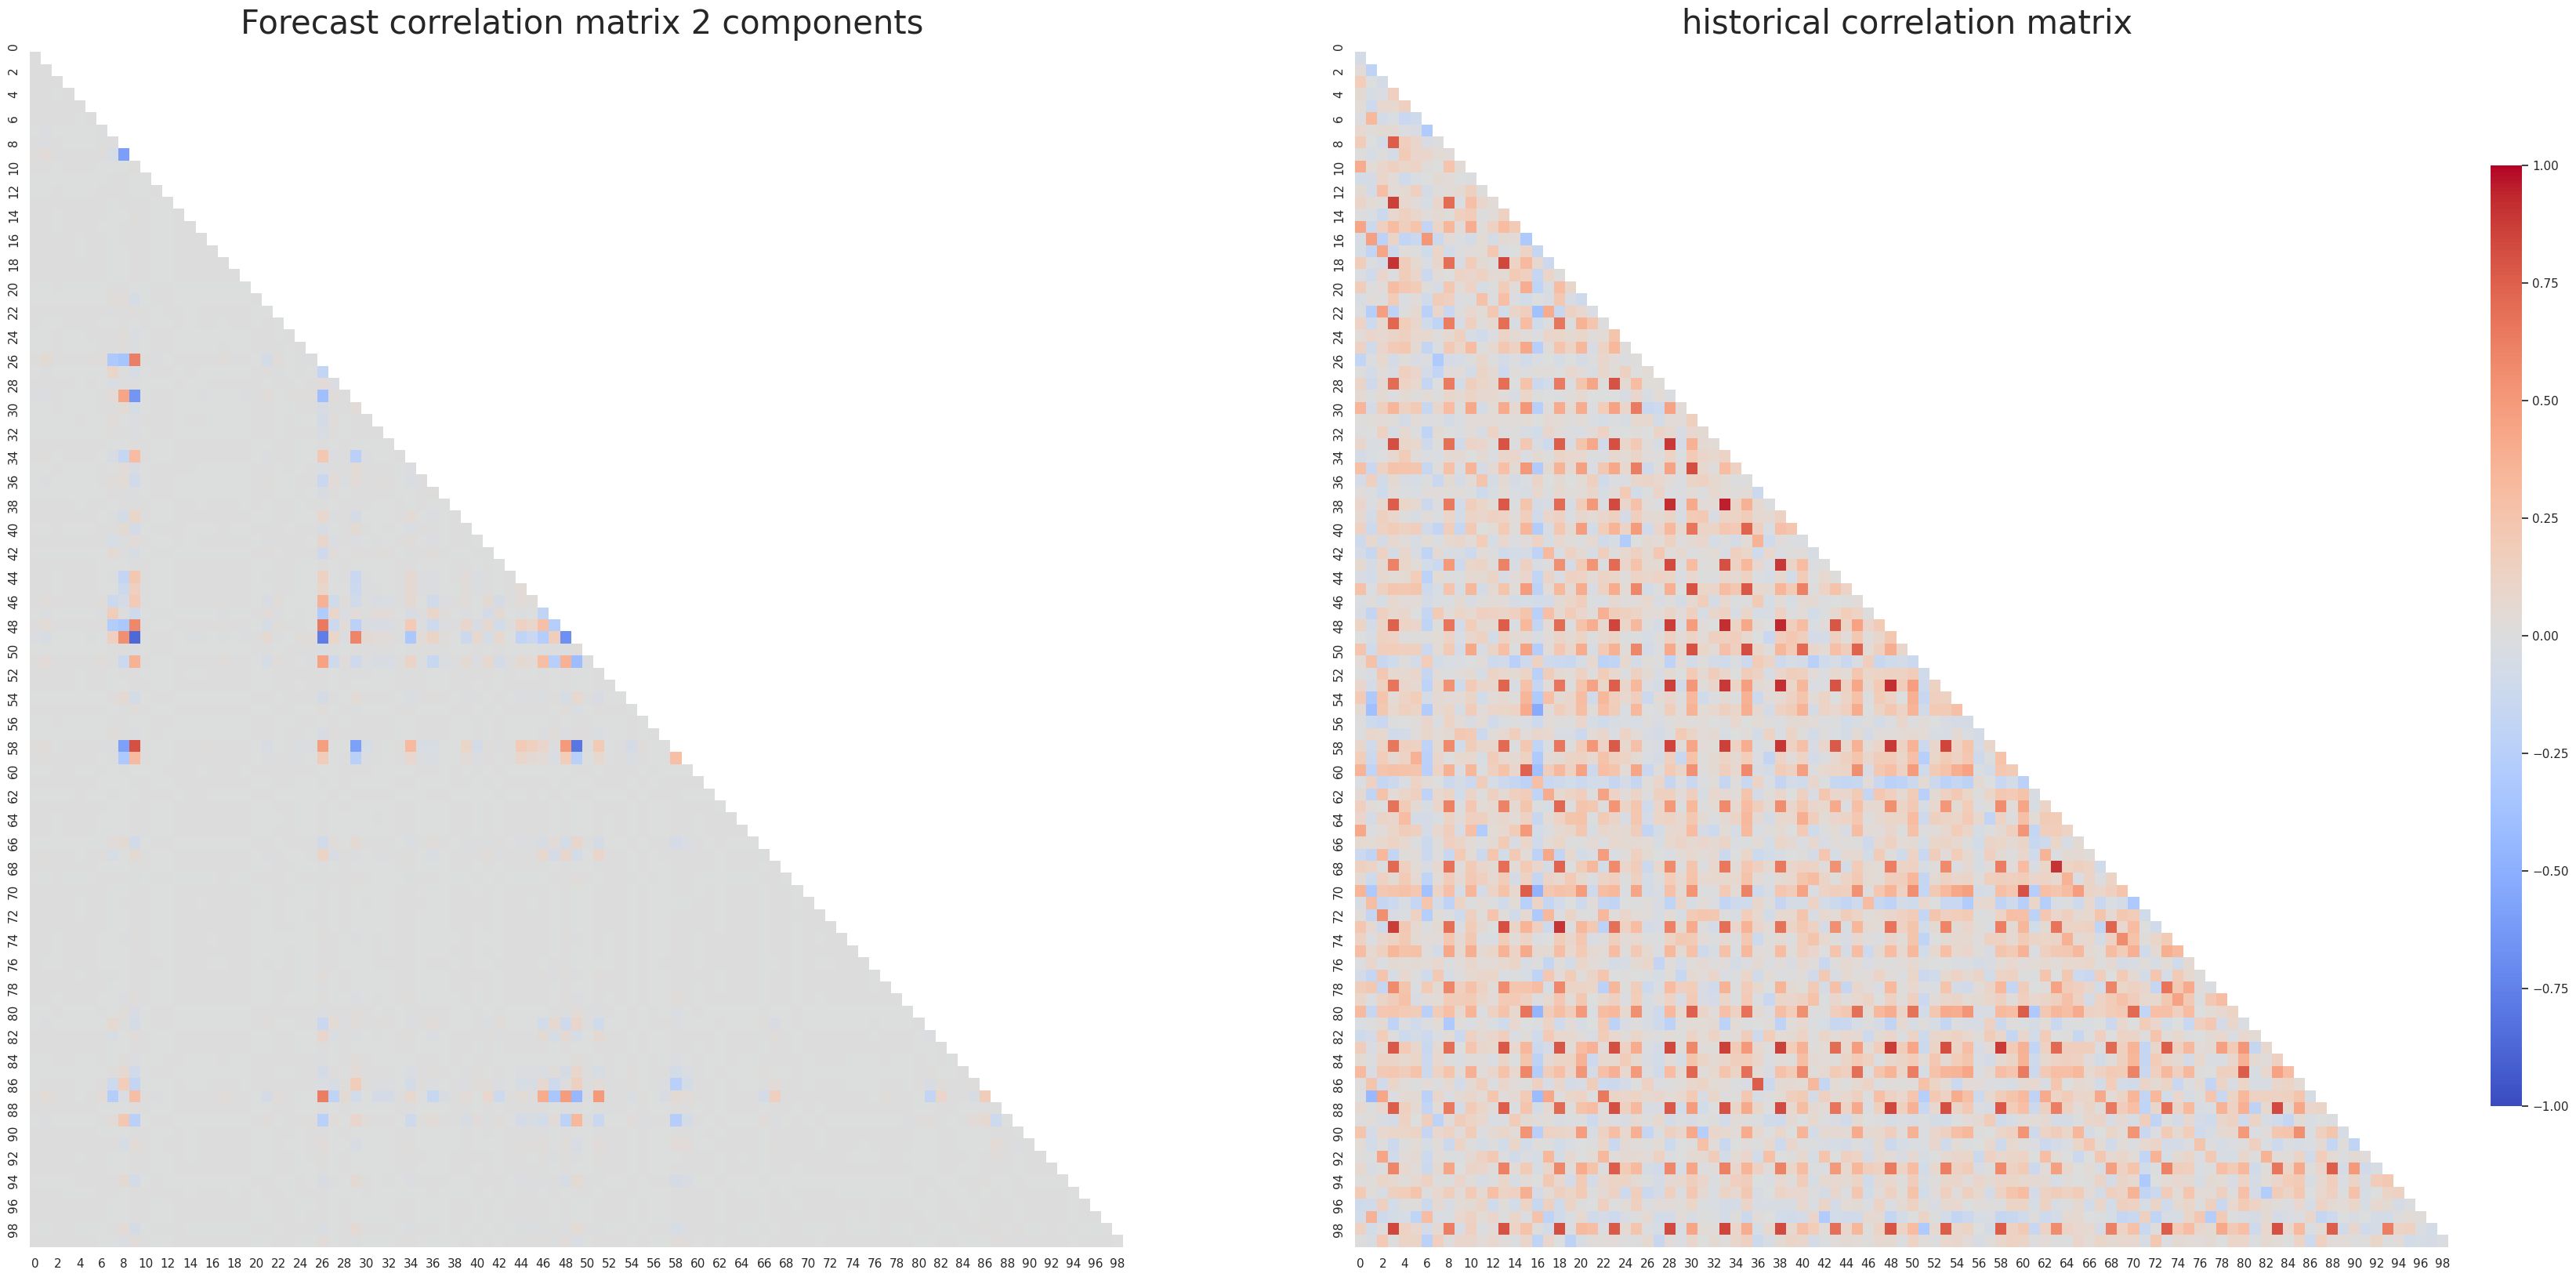

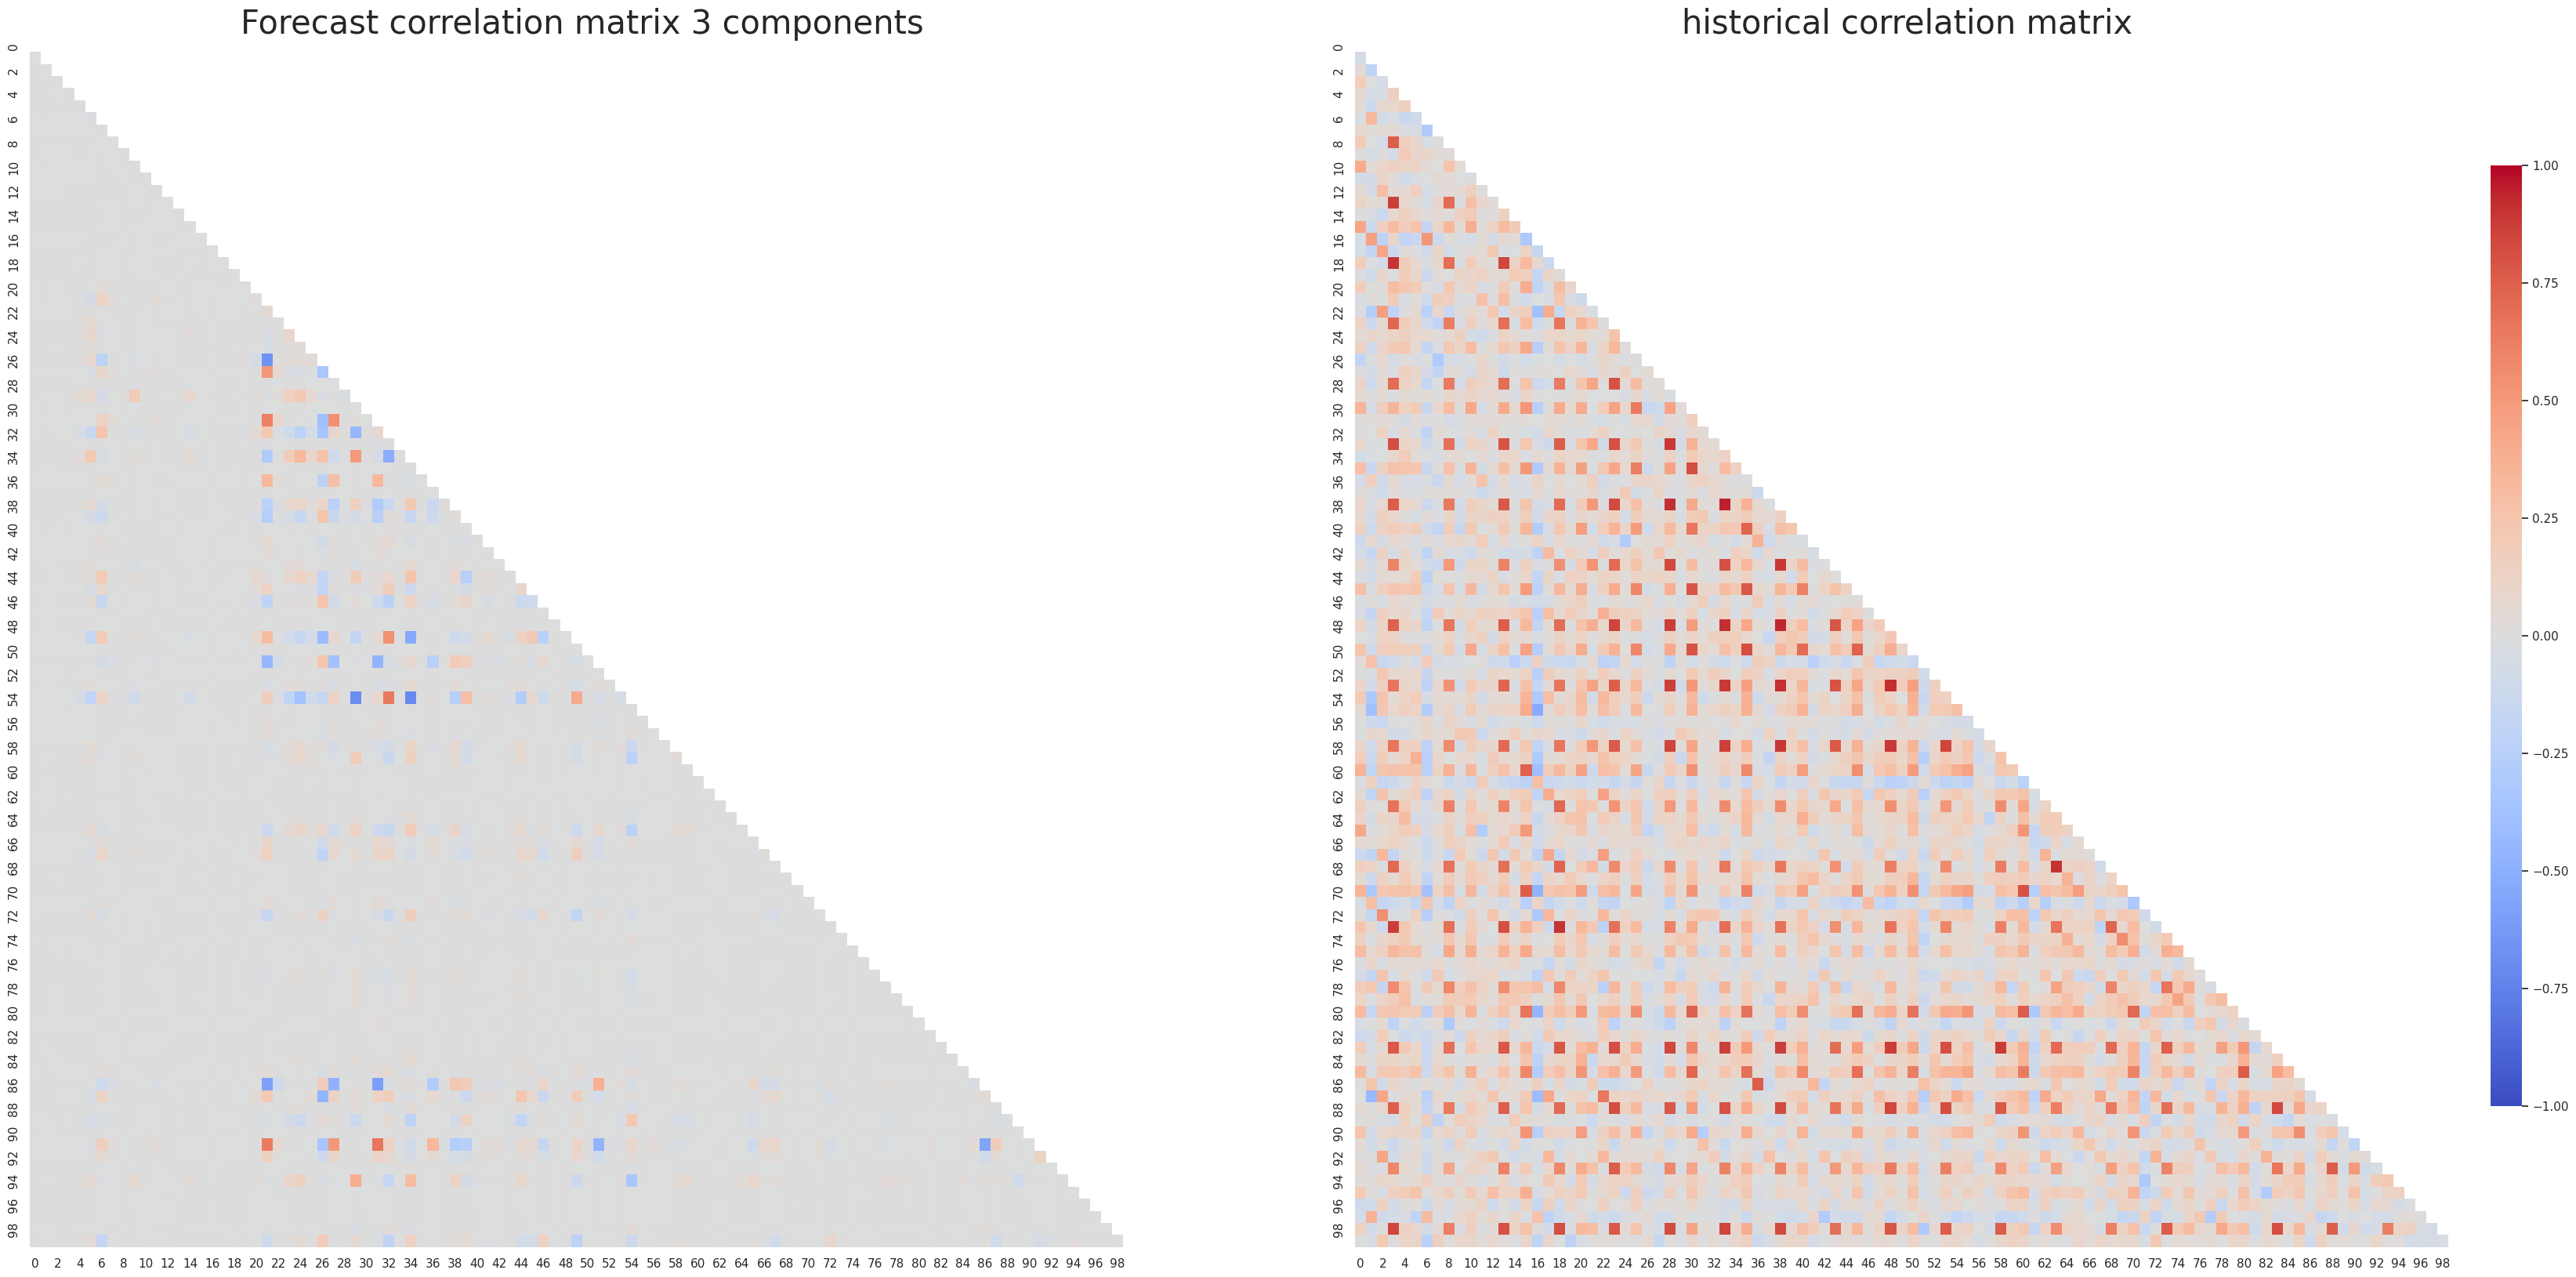

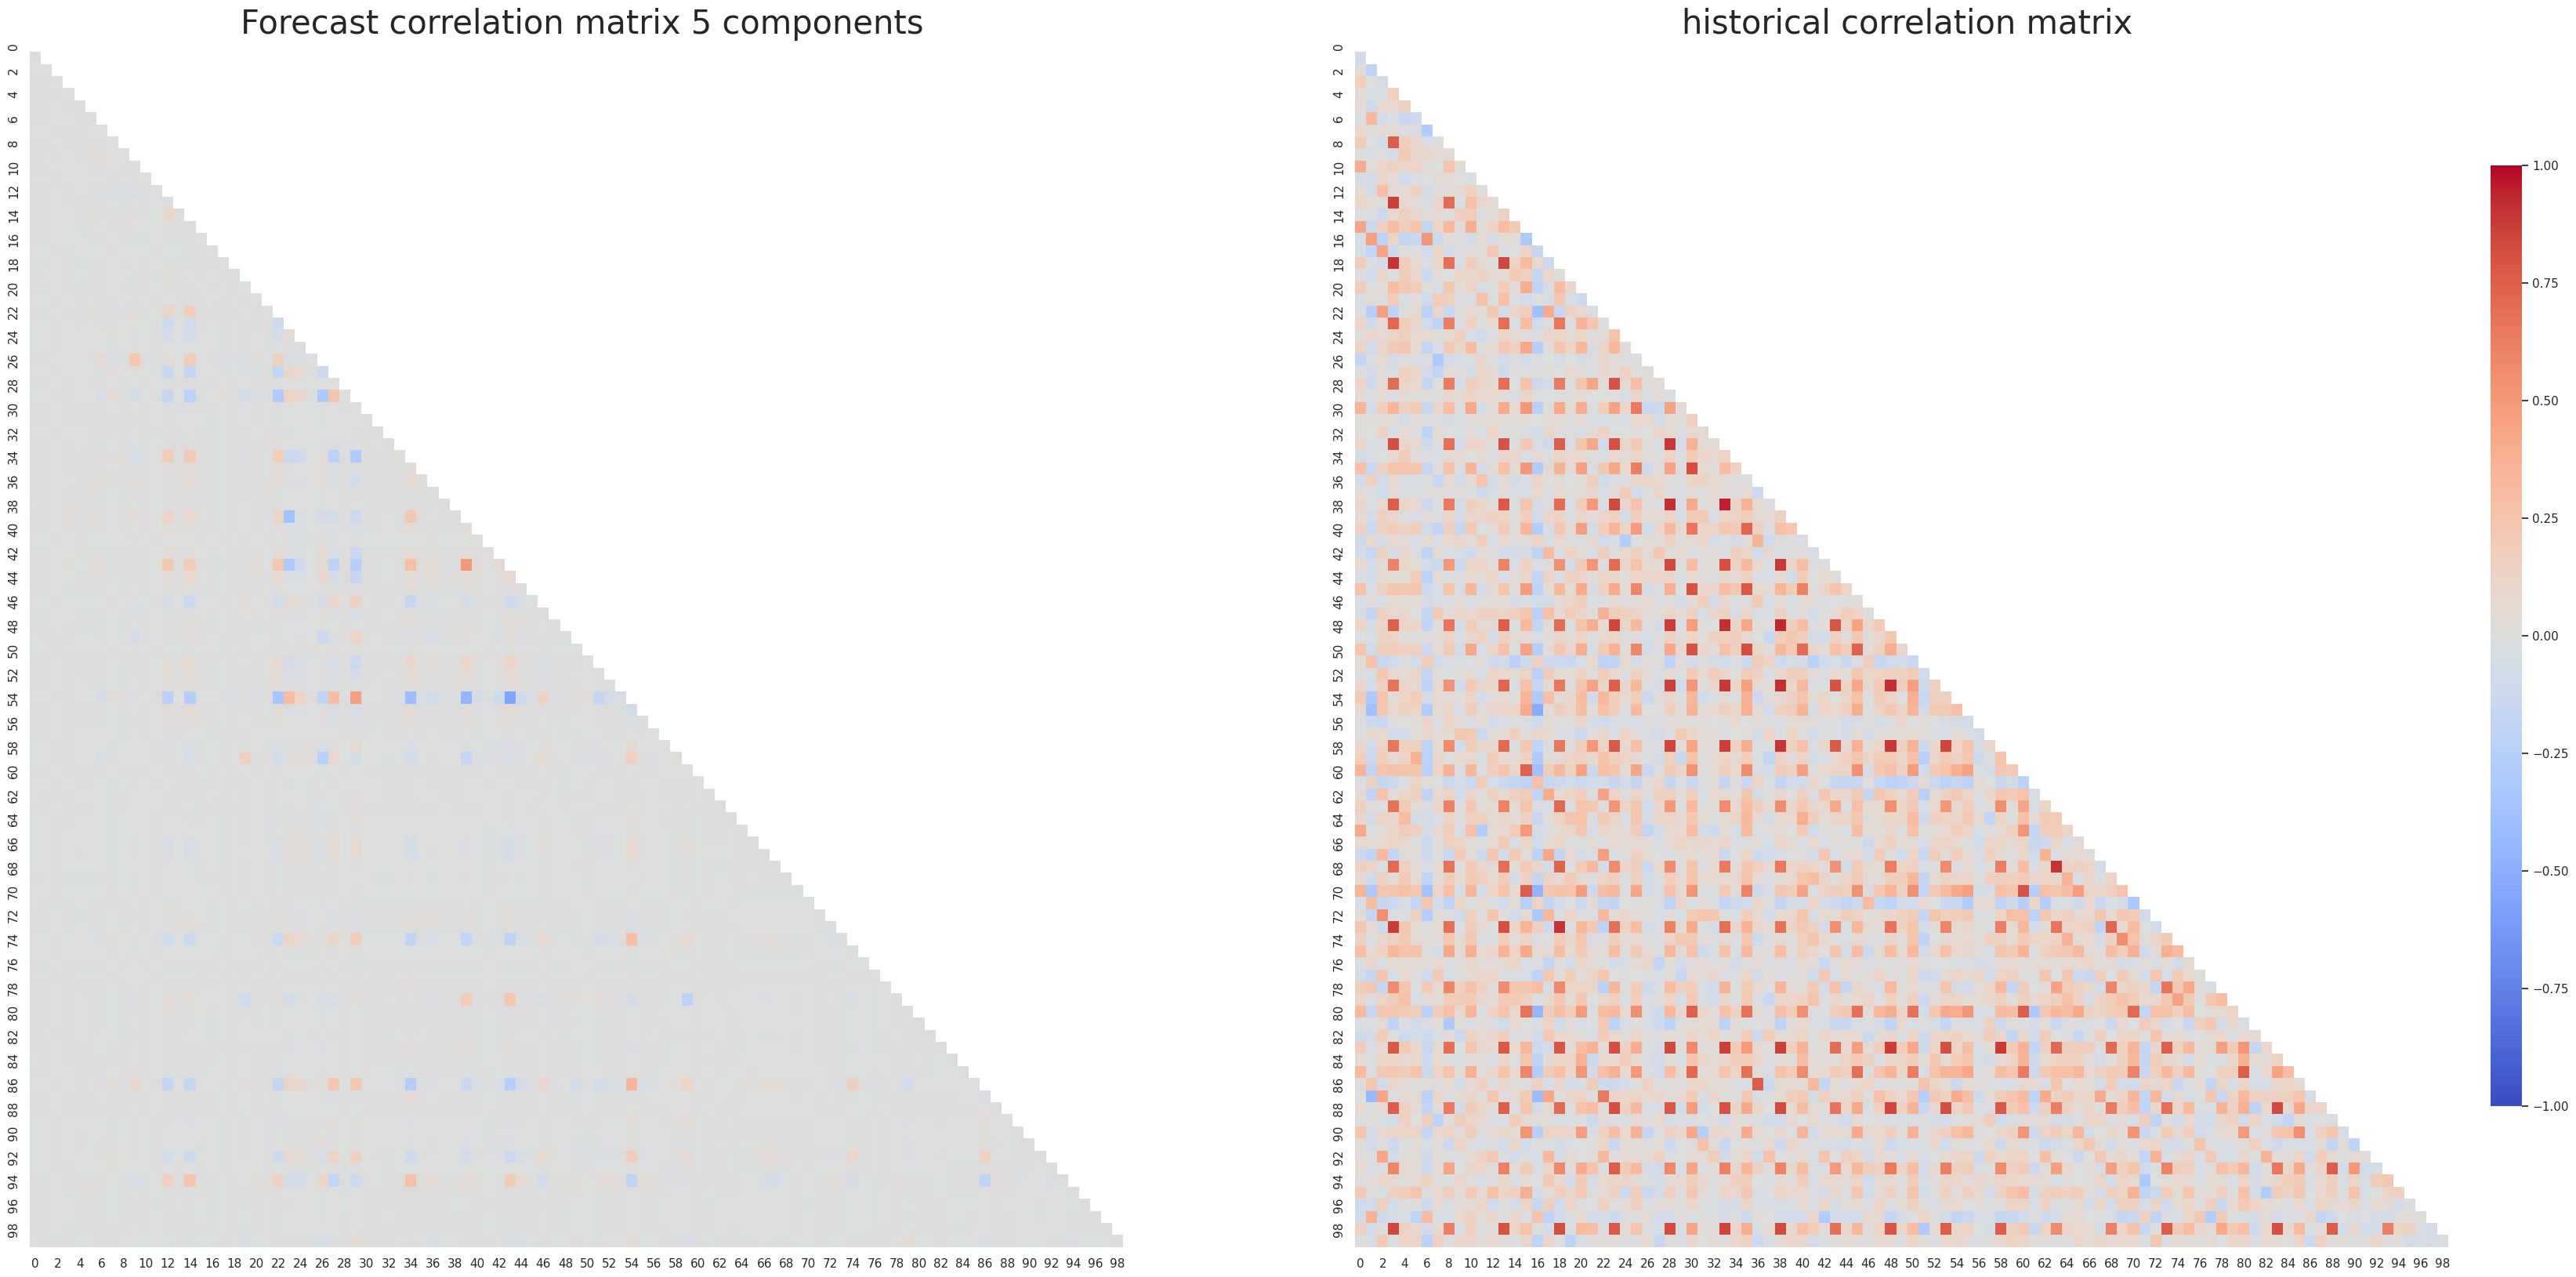

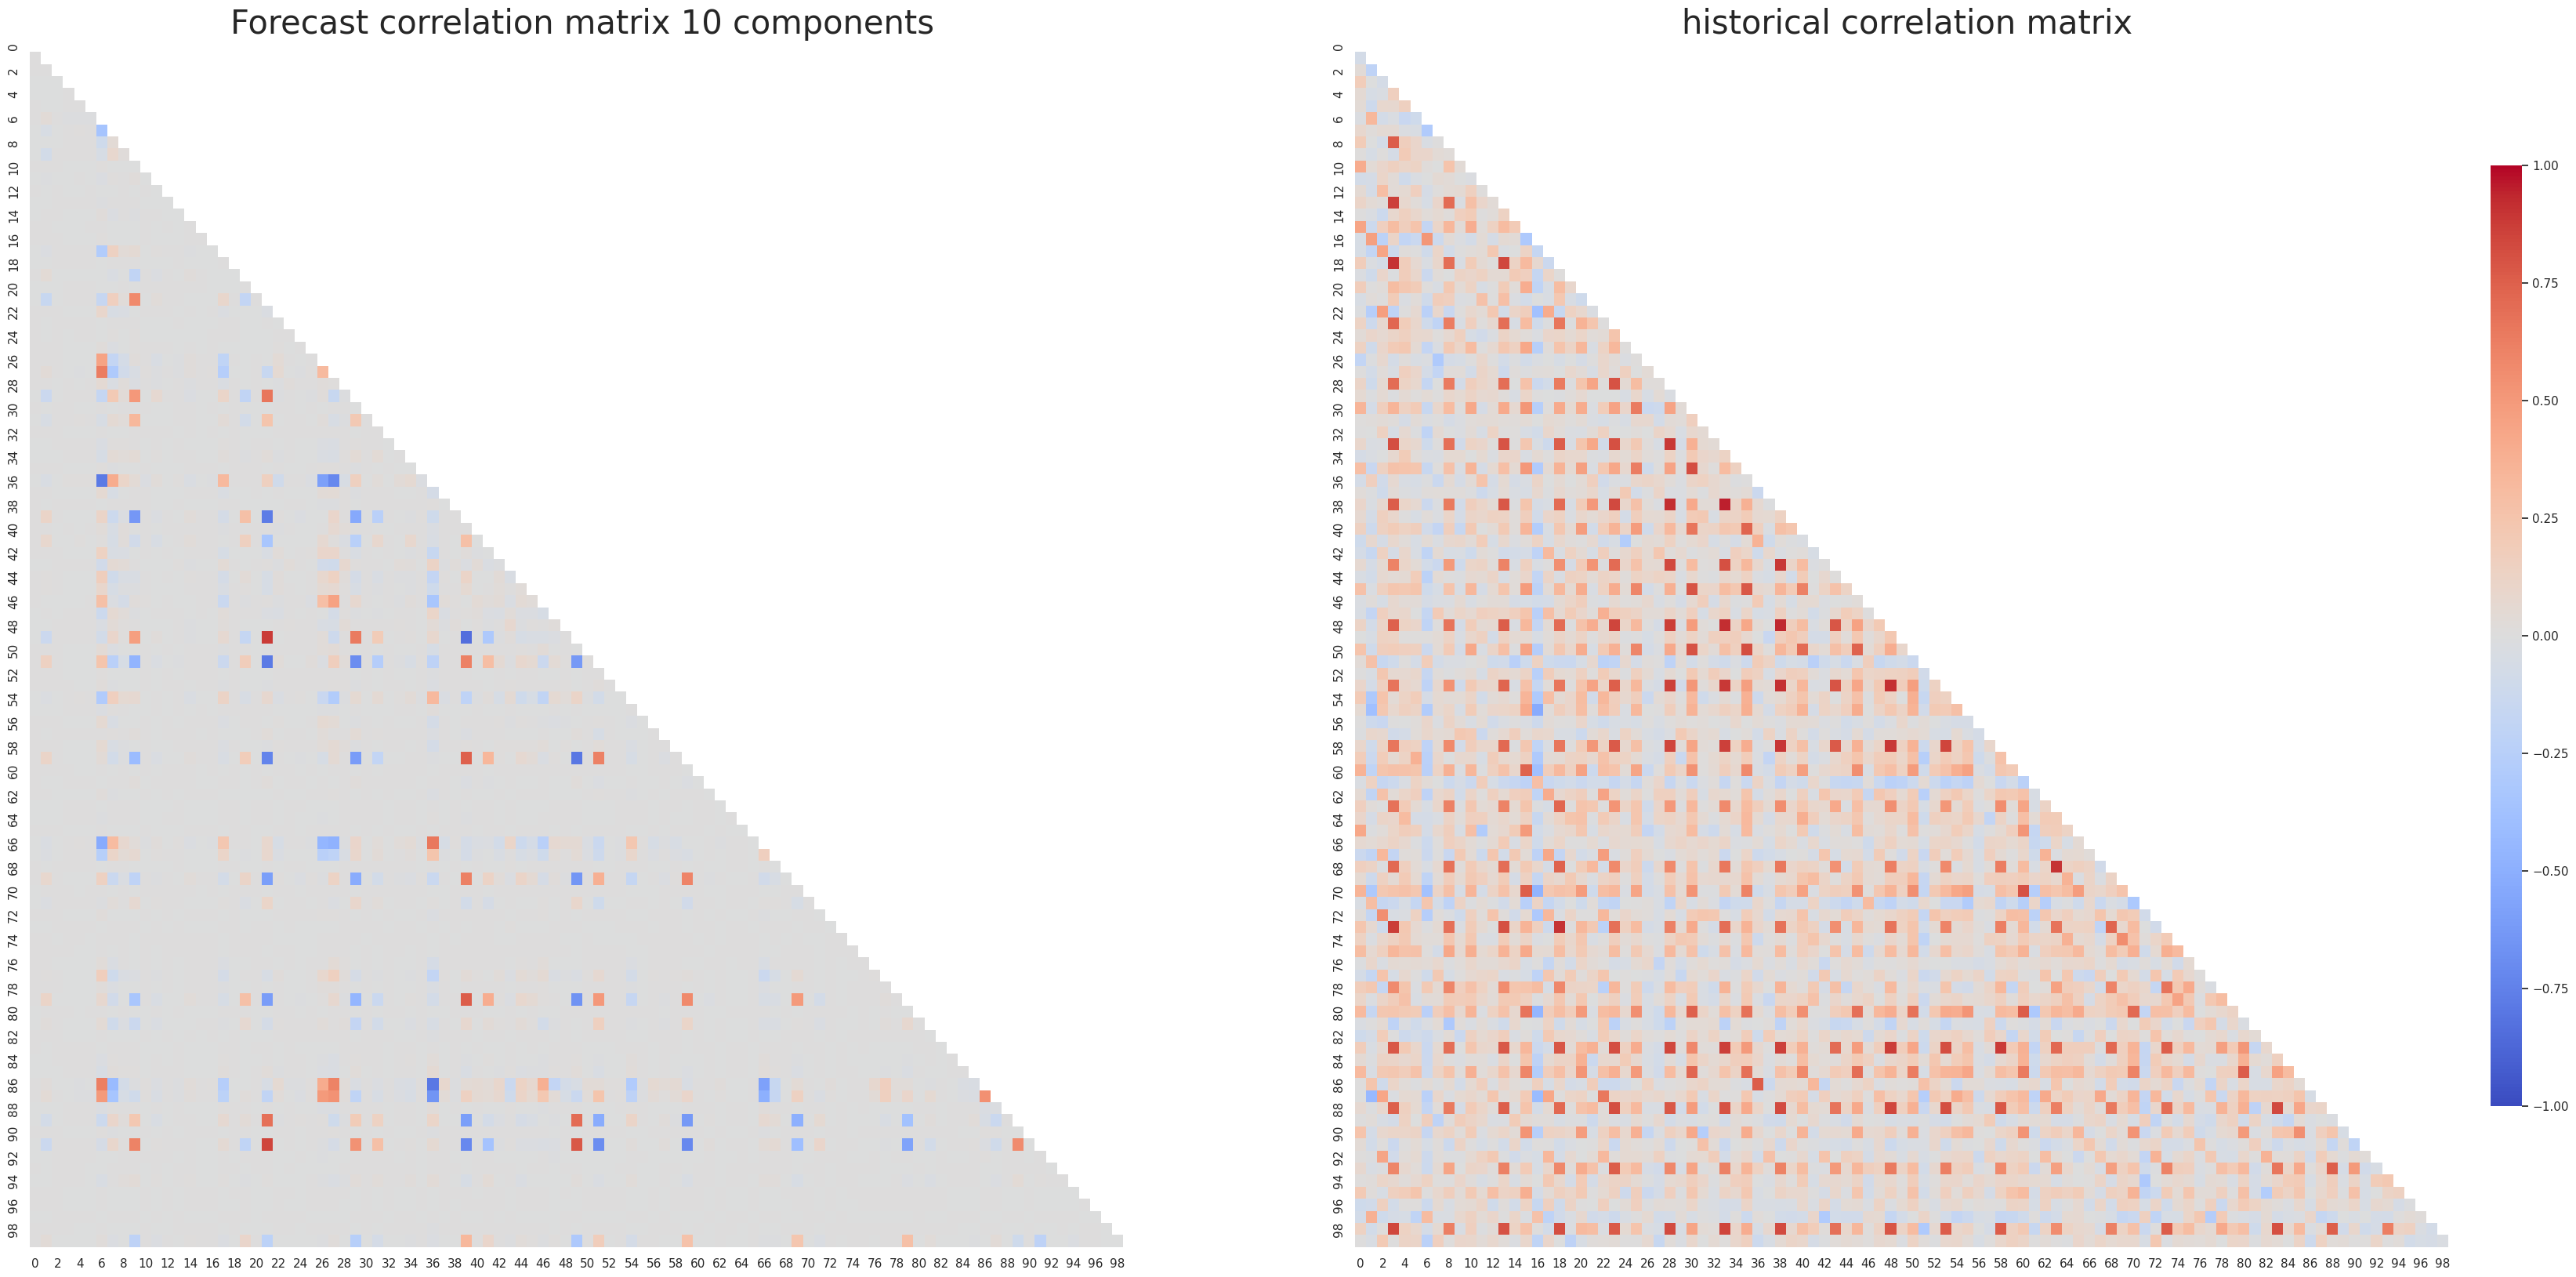

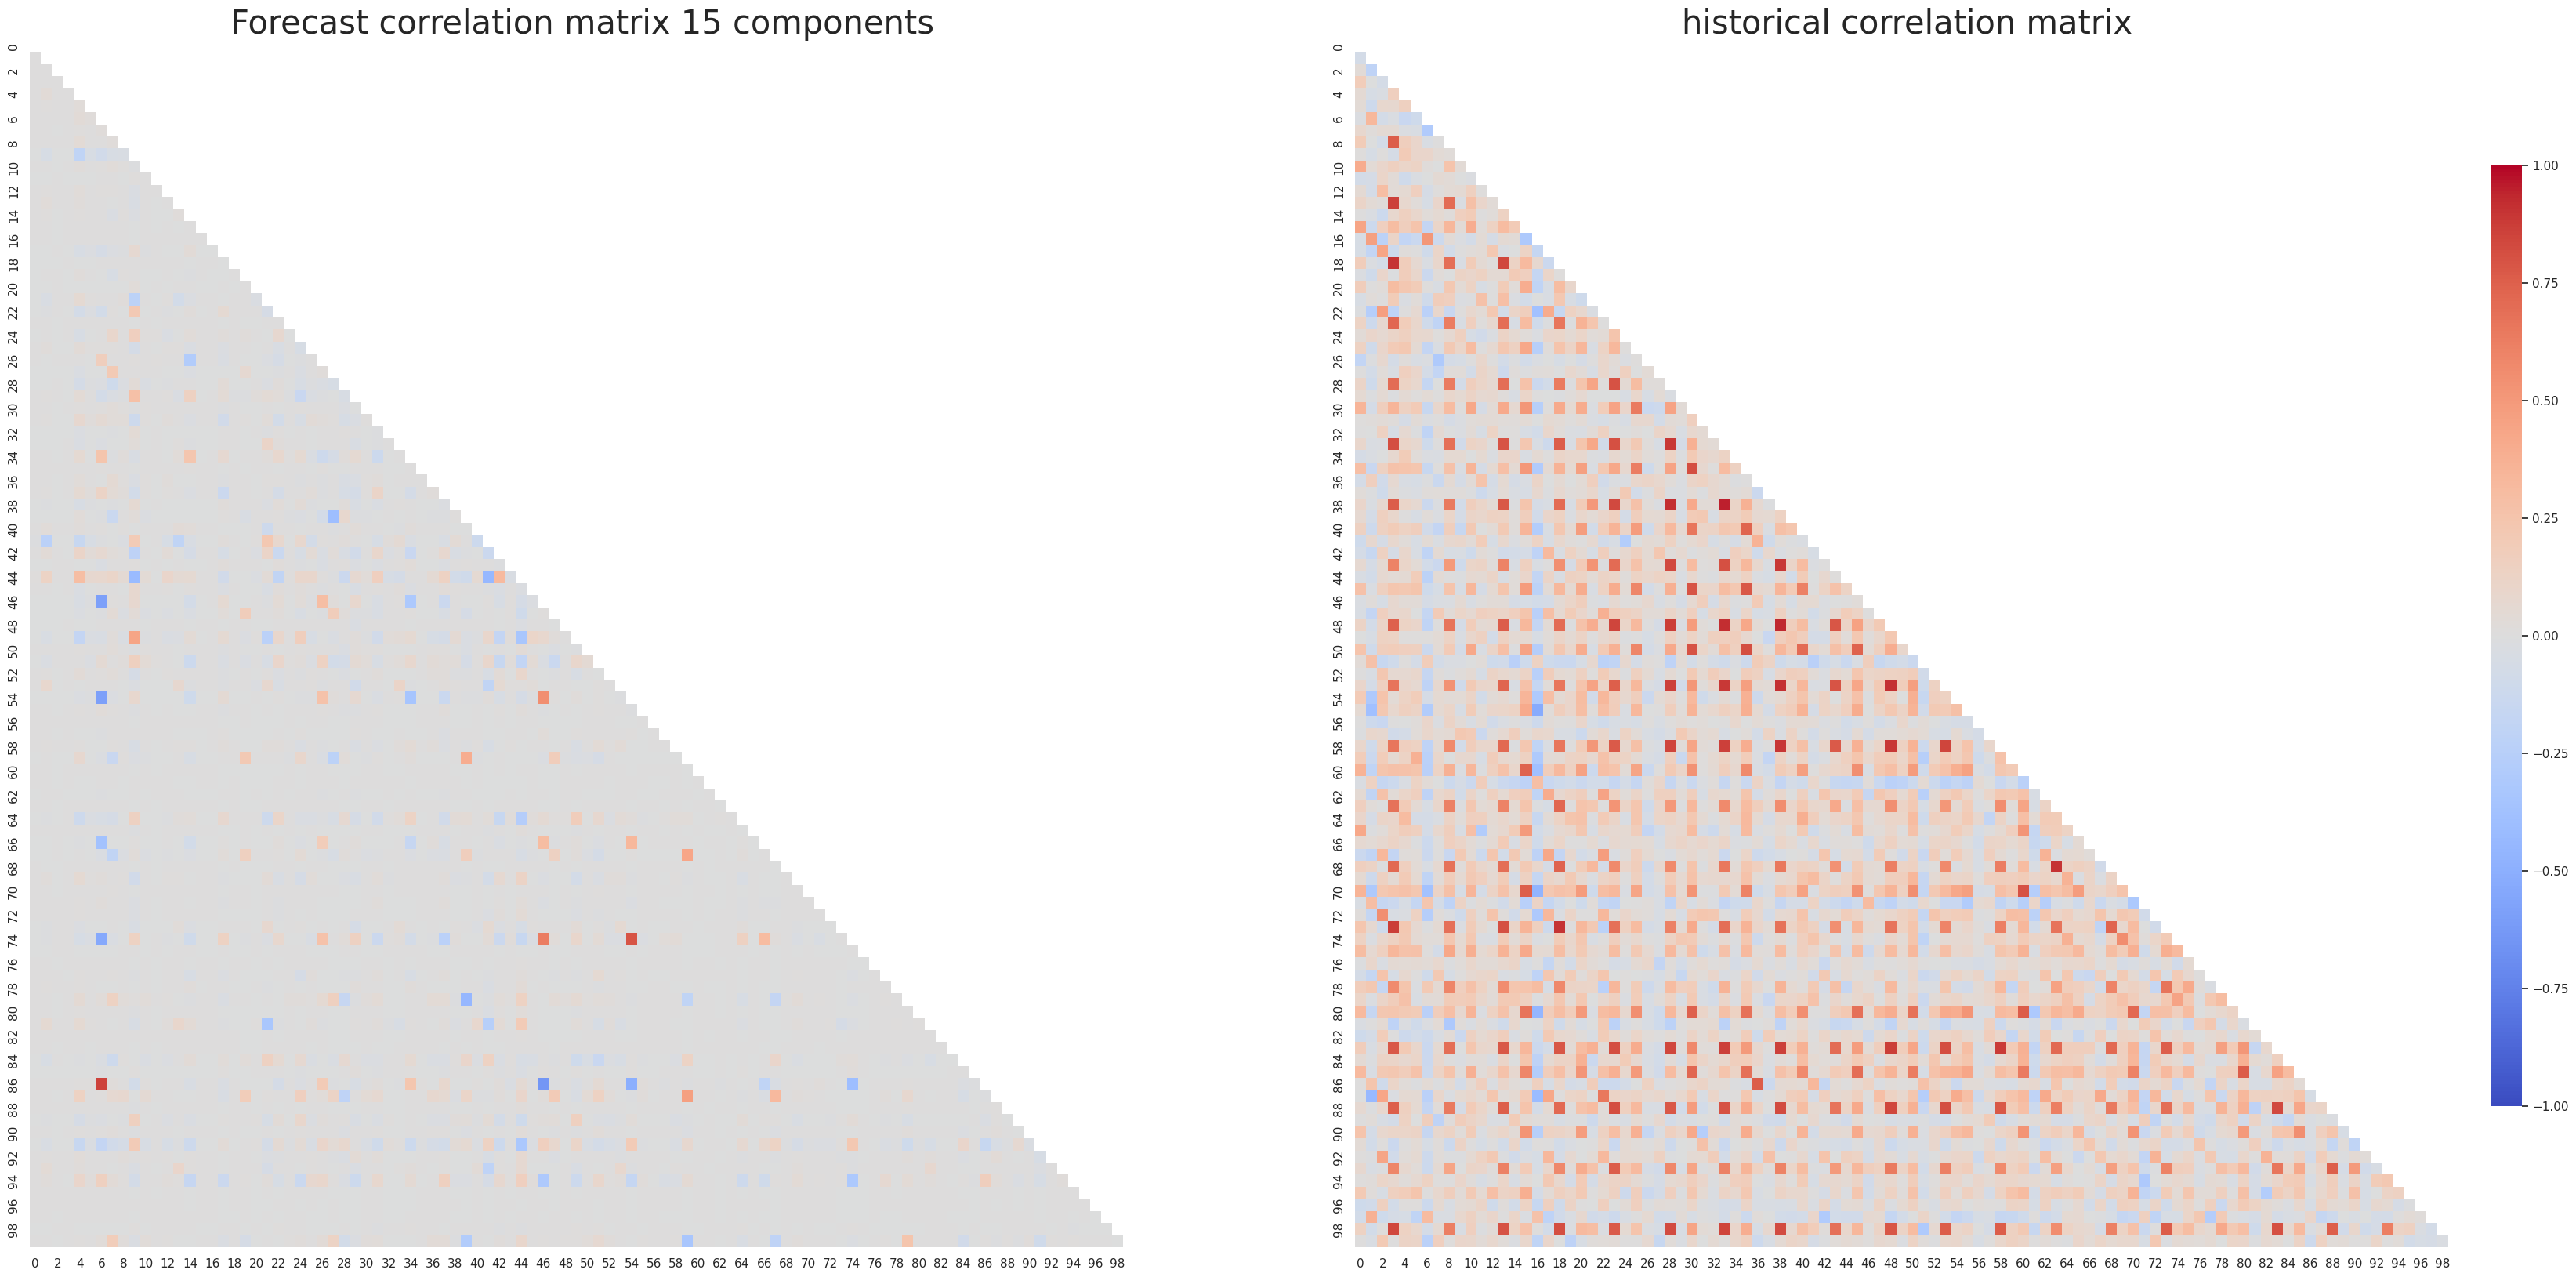

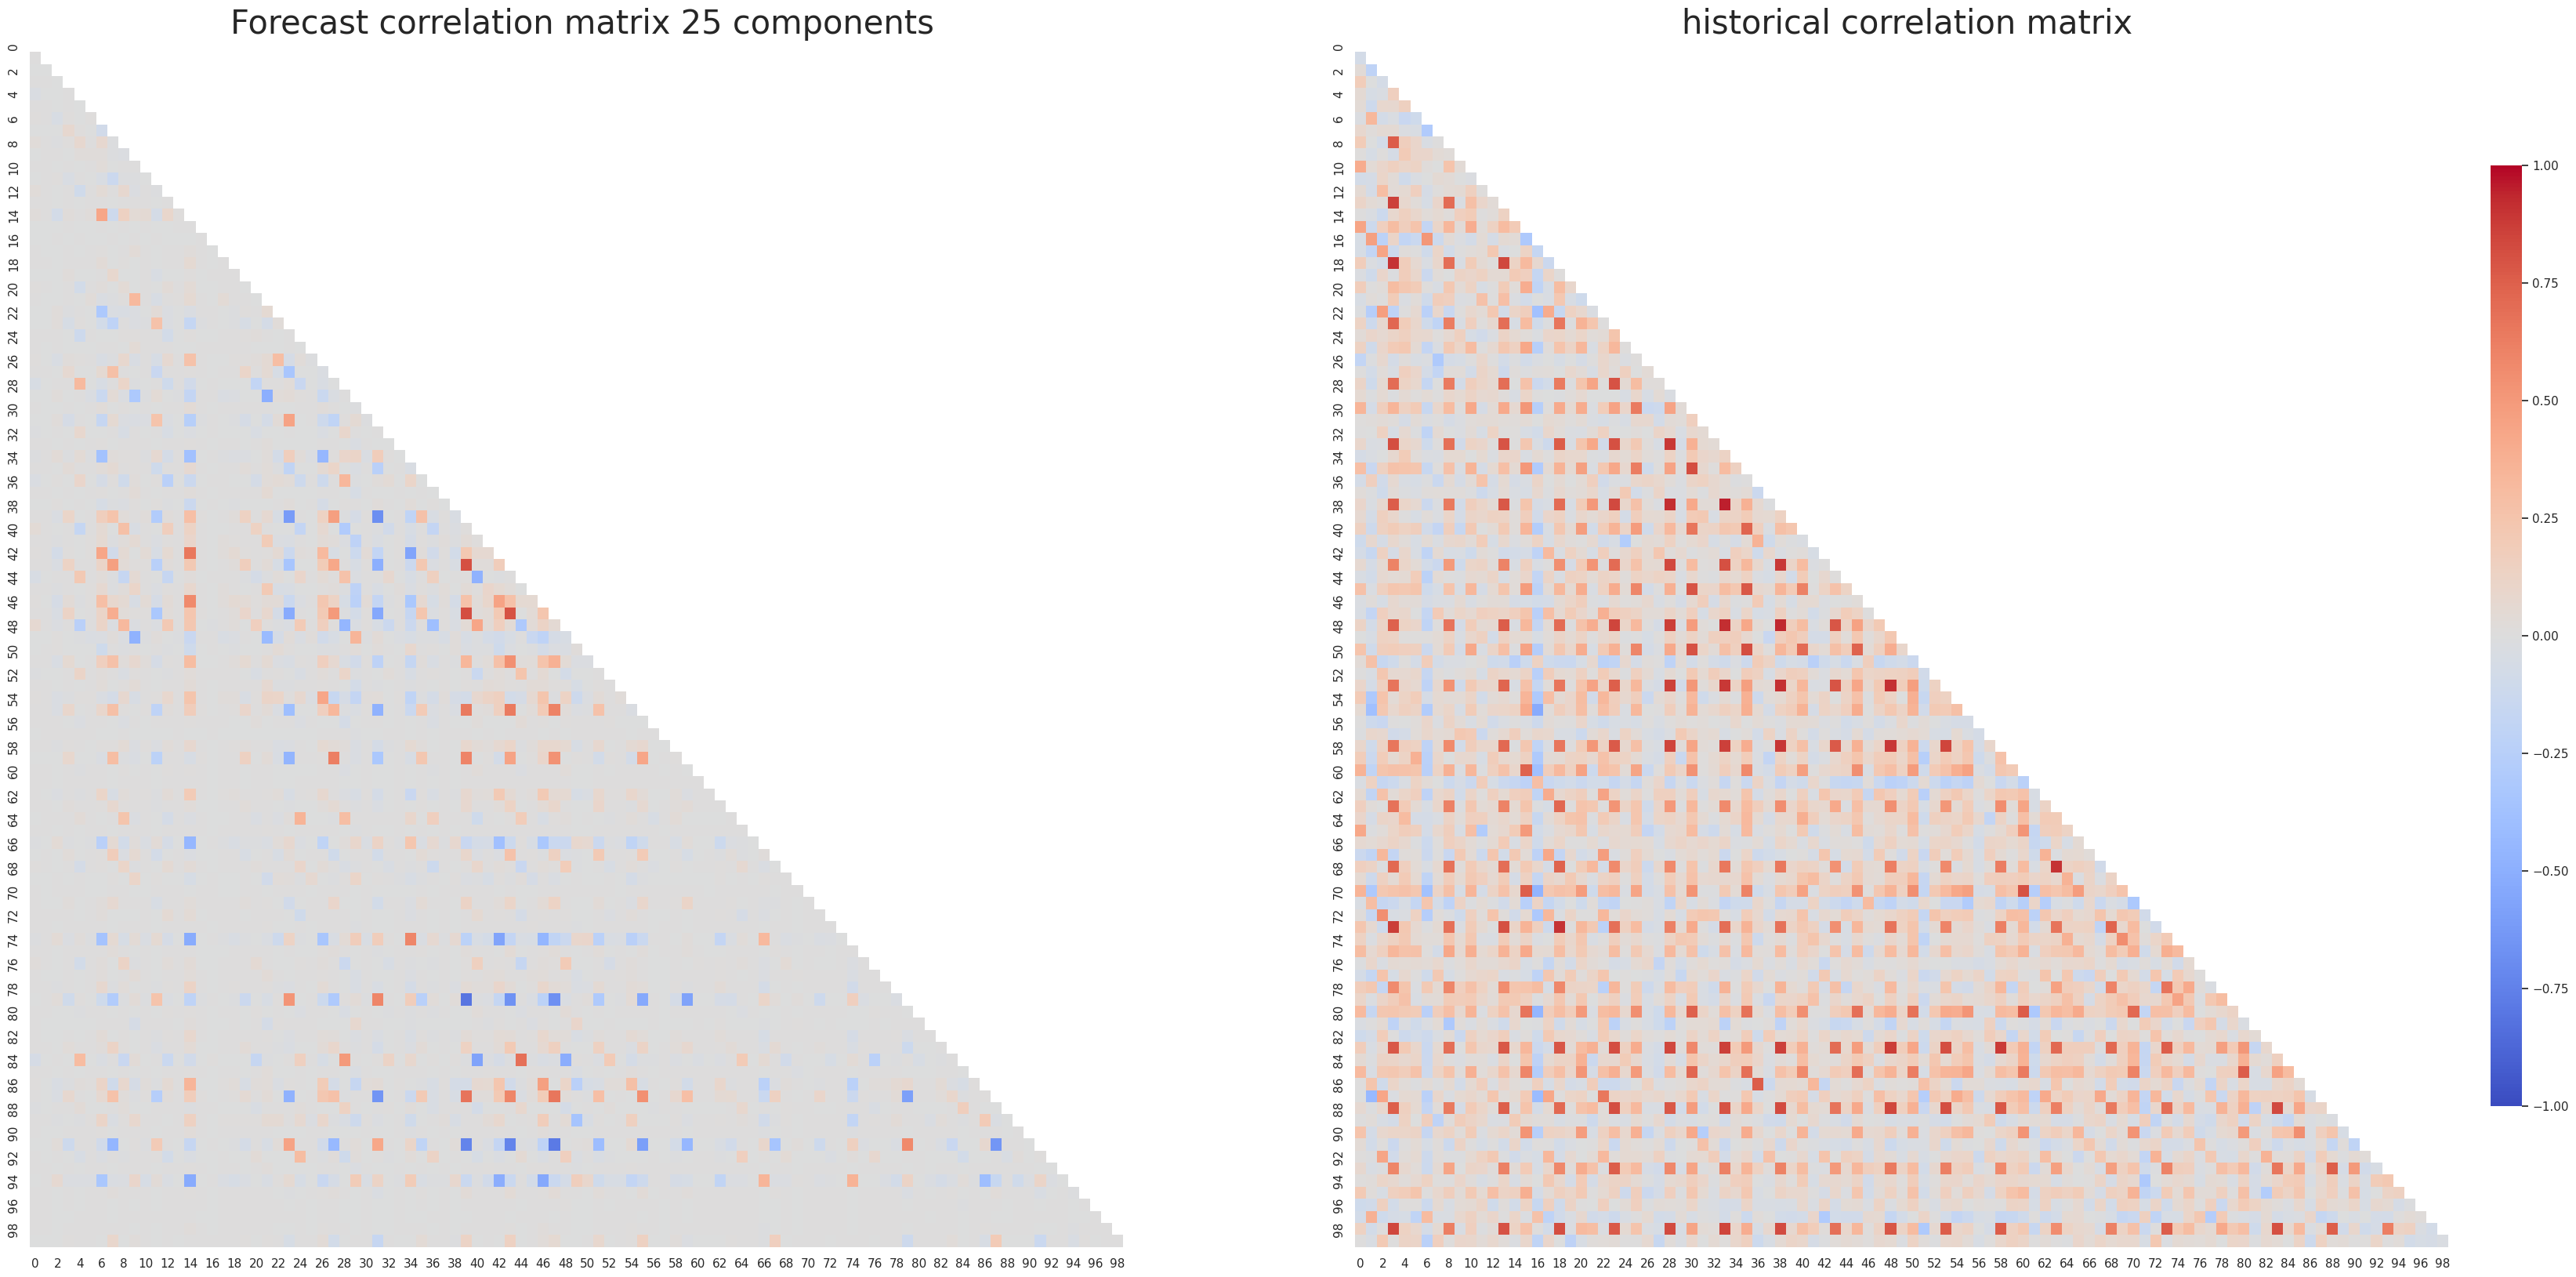

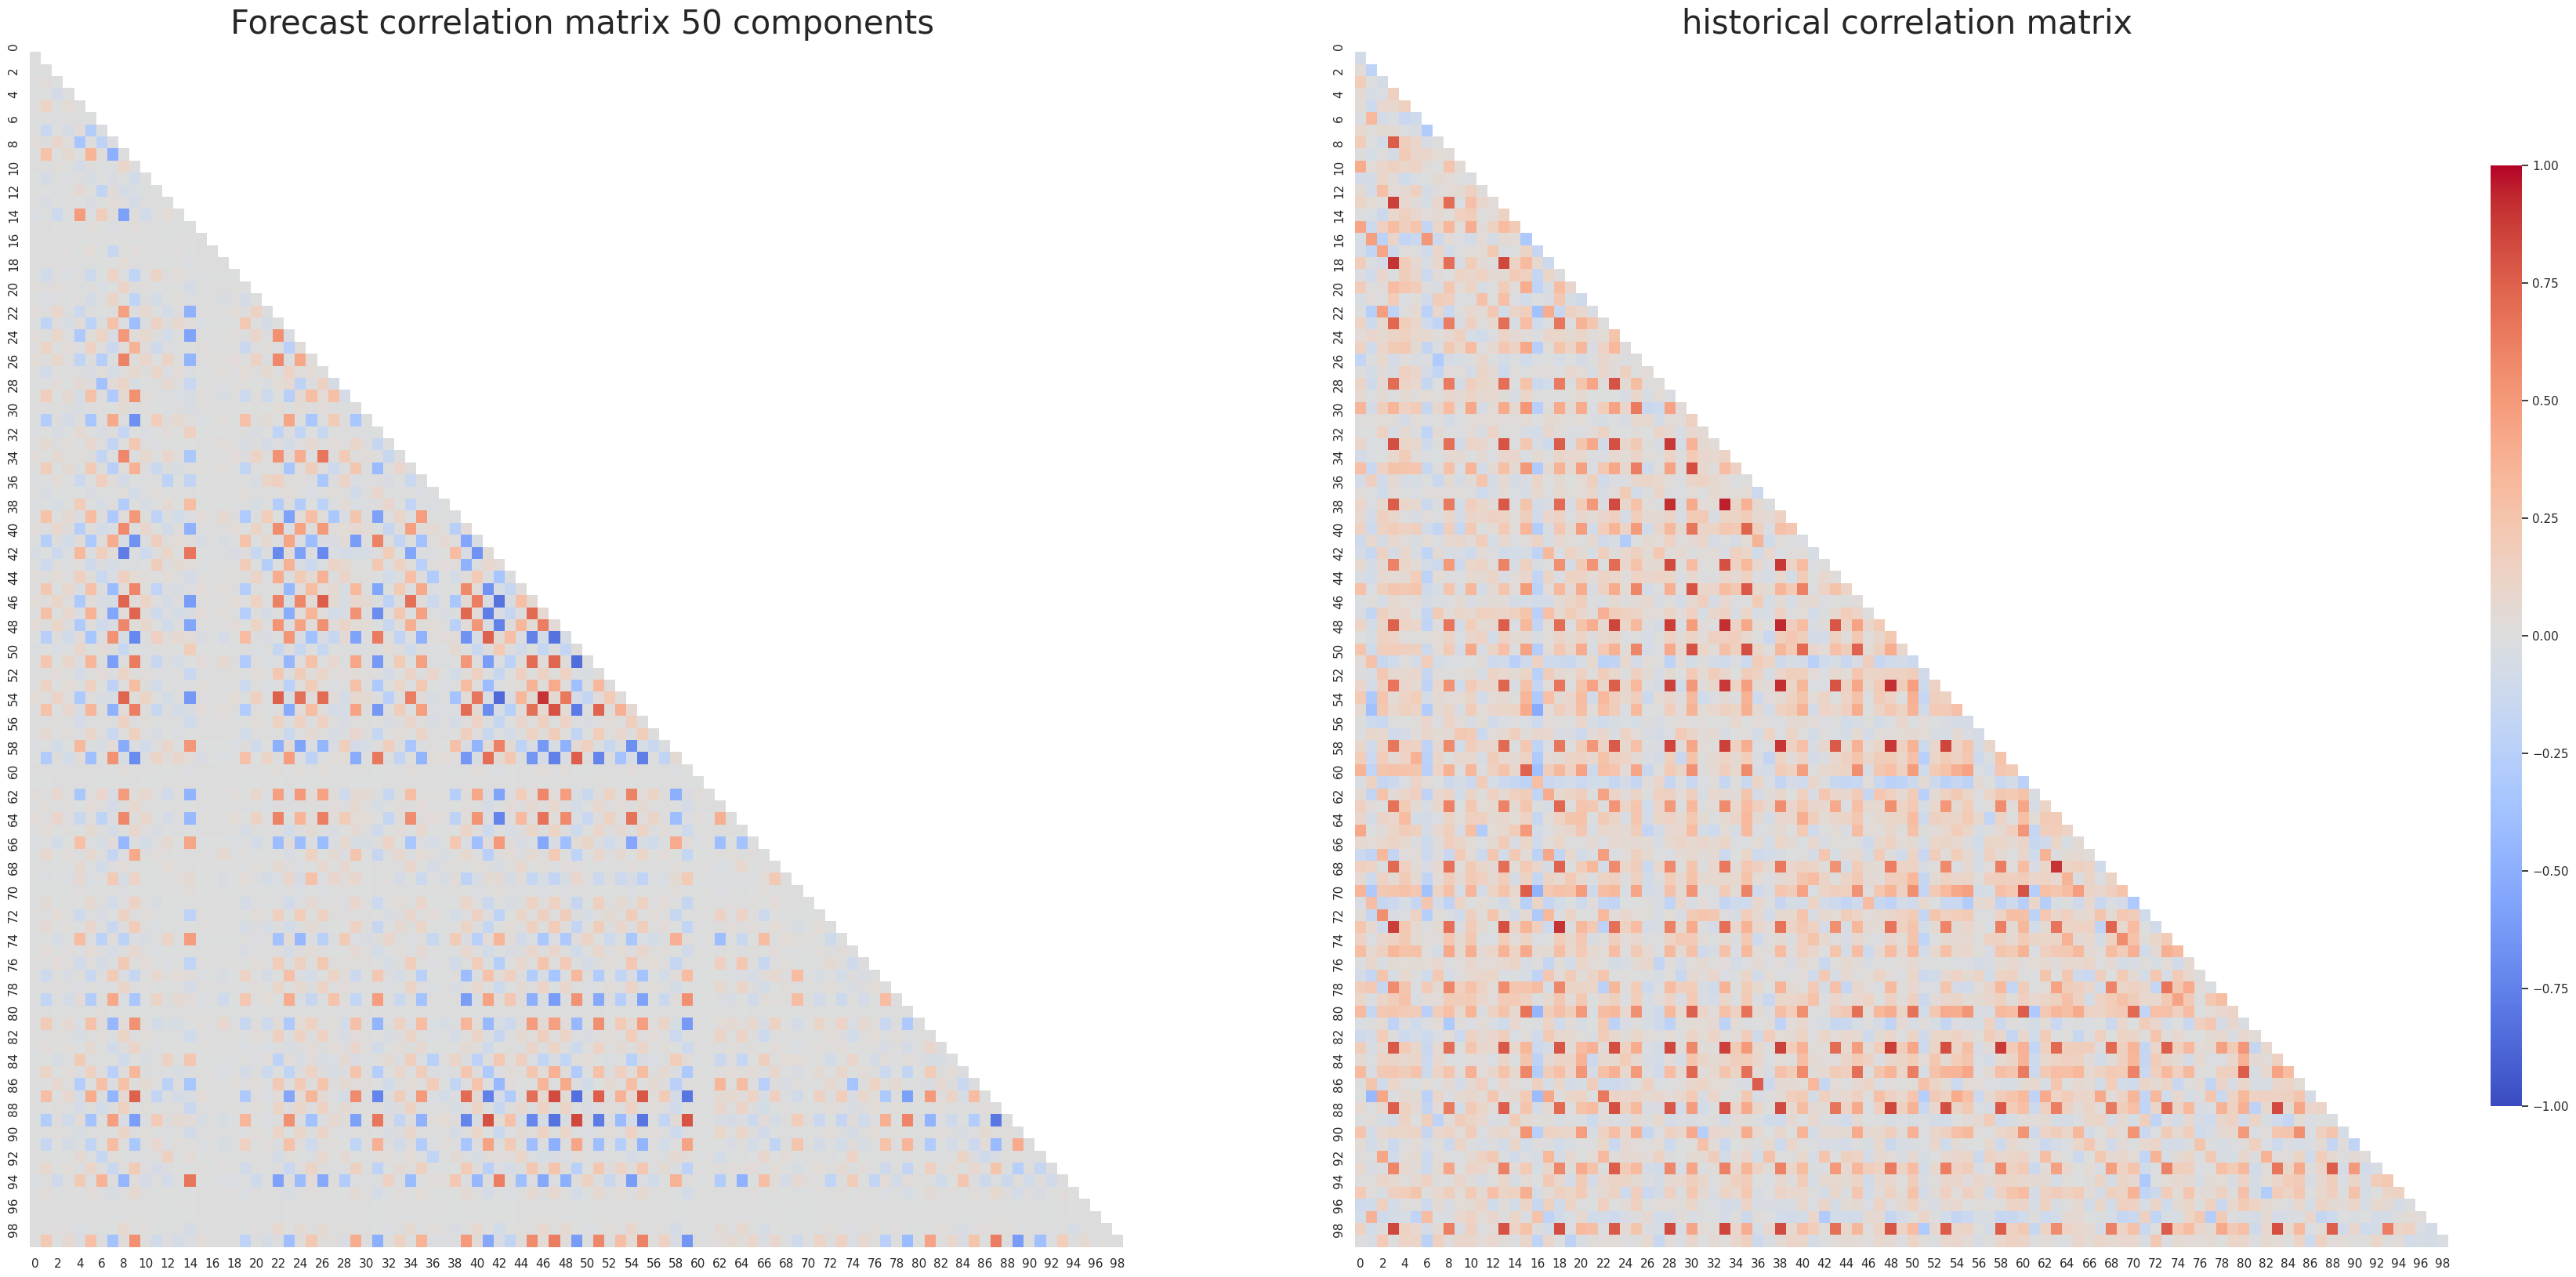

In [7]:
for i,ss in enumerate([2,3,5,10,15,25,50]):
    final_path =  f'./checkpoints/CLOVER_NHITS_{ss}_12_2_CRPS.ckpt'
    # model_prob = NHITS_CLOVER.load_from_checkpoint(final_path)
    model_prob = NHITS_CLOVER.load_from_checkpoint(final_path)
    seq_len = 12   
    Y_hat = pd.DataFrame()
    cutoff = [df.index[-1] +  pd.Timedelta(days=1) - pd.DateOffset(months=(i)) - pd.Timedelta(days=1) for i in range(24,5, -1)]
    for j,a in enumerate(cutoff):
        cutin = df_nodate[df_nodate['date'] == a].index[0]
        input = torch.tensor(df_nodate.iloc[cutin-(seq_len-1):cutin+1, :-1].values).unsqueeze(0)
        true = torch.tensor(df_nodate.iloc[cutin+1:cutin+7, :-1].values).unsqueeze(0)
        model_prob.eval()
        mu,std,vec,z = model_prob.forward(batch = [input.float().to('cuda:0'),true.float().to('cuda:0')], batch_idx=0, n_samples=1000)
        if j == 0 :
            Vec = vec
            Std = std
        else :
            Vec = torch.concatenate((Vec, vec), dim = 0)
            Std = torch.concatenate((Std, std), dim = 0)

    sig = torch.diag_embed(torch.square(Std), dim1 = -2, dim2 = -1)
    F = vec @ vec.permute((0,1,3,2))
    covmat = torch.mean(sig+F, axis = (0,1)).detach().cpu()
    std_dev = np.sqrt(np.diag(covmat))
    std_dev_matrix = np.diag(std_dev)
    std_dev_matrix1 = np.diag(1/std_dev)
    # Calculate the correlation matrix
    # correlation_matrix = np.linalg.solve(std_dev_matrix, np.linalg.solve(std_dev_matrix, covmat))
    correlation_matrix = std_dev_matrix1 @ np.array(covmat) @ std_dev_matrix1
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    fig, axs = plt.subplots(1,2,figsize = (40,20))
    cbar_ax = fig.add_axes([.91, .2, .01, .6])
    sns.heatmap(correlation_matrix, mask = mask, vmin = -1, vmax =1, cmap = 'coolwarm', cbar = True, annot =False, ax = axs[0],
                cbar_ax=cbar_ax
                )
    df_corr = df.iloc[:,:].drop(columns=['date']).pct_change().corr().iloc[26:,26:] 
    axs[0].set_title(f'Forecast correlation matrix {ss} components',fontsize=30)
    axs[1].set_title(f'historical correlation matrix',fontsize=30)
    mask = np.triu(np.ones_like(df_corr, dtype=bool))
    sns.heatmap(df_corr.values, mask = mask, vmax =1, vmin = -1, cmap = 'coolwarm', ax = axs[1], cbar = False)

    plt.savefig(f'./images/frame_{i}', dpi = 100, transparent = True)

In [8]:
images = []
for n in range(6):
    exec('a'+str(n)+'=Image.open("./images/frame_'+str(n)+'.png")')
    images.append(eval('a'+str(n)))
images[0].save('anim_corr.gif',
               save_all=True,
               append_images=images[1:],
               disposal = 2,
               dpi = 100,
               duration = 1000,
               loop=0)

In [2]:
models_dict = {
    'NHITS' : NHITS_CLOVER
}
recon = [2,3,5,10,15]
seed = ['CRPS']
runs = [0,1,2]
eval_CLOVER, Y_fin, _ = evaluation('CLOVER', models_dict, recon, seed, runs)

/tmp/ipykernel_650523/3137096126.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(evs, y='value', x = 'variable', ax = axs[k], order = evs.variable.unique(), palette = 'husl')
/tmp/ipykernel_650523/3137096126.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(evs, y='value', x = 'variable', ax = axs[k], order = evs.variable.unique(), palette = 'husl')
/tmp/ipykernel_650523/3137096126.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(evs, y='value', x = 'variable', ax = axs[k], order = evs.variable.unique(), palette = 'husl')
/tmp/ip

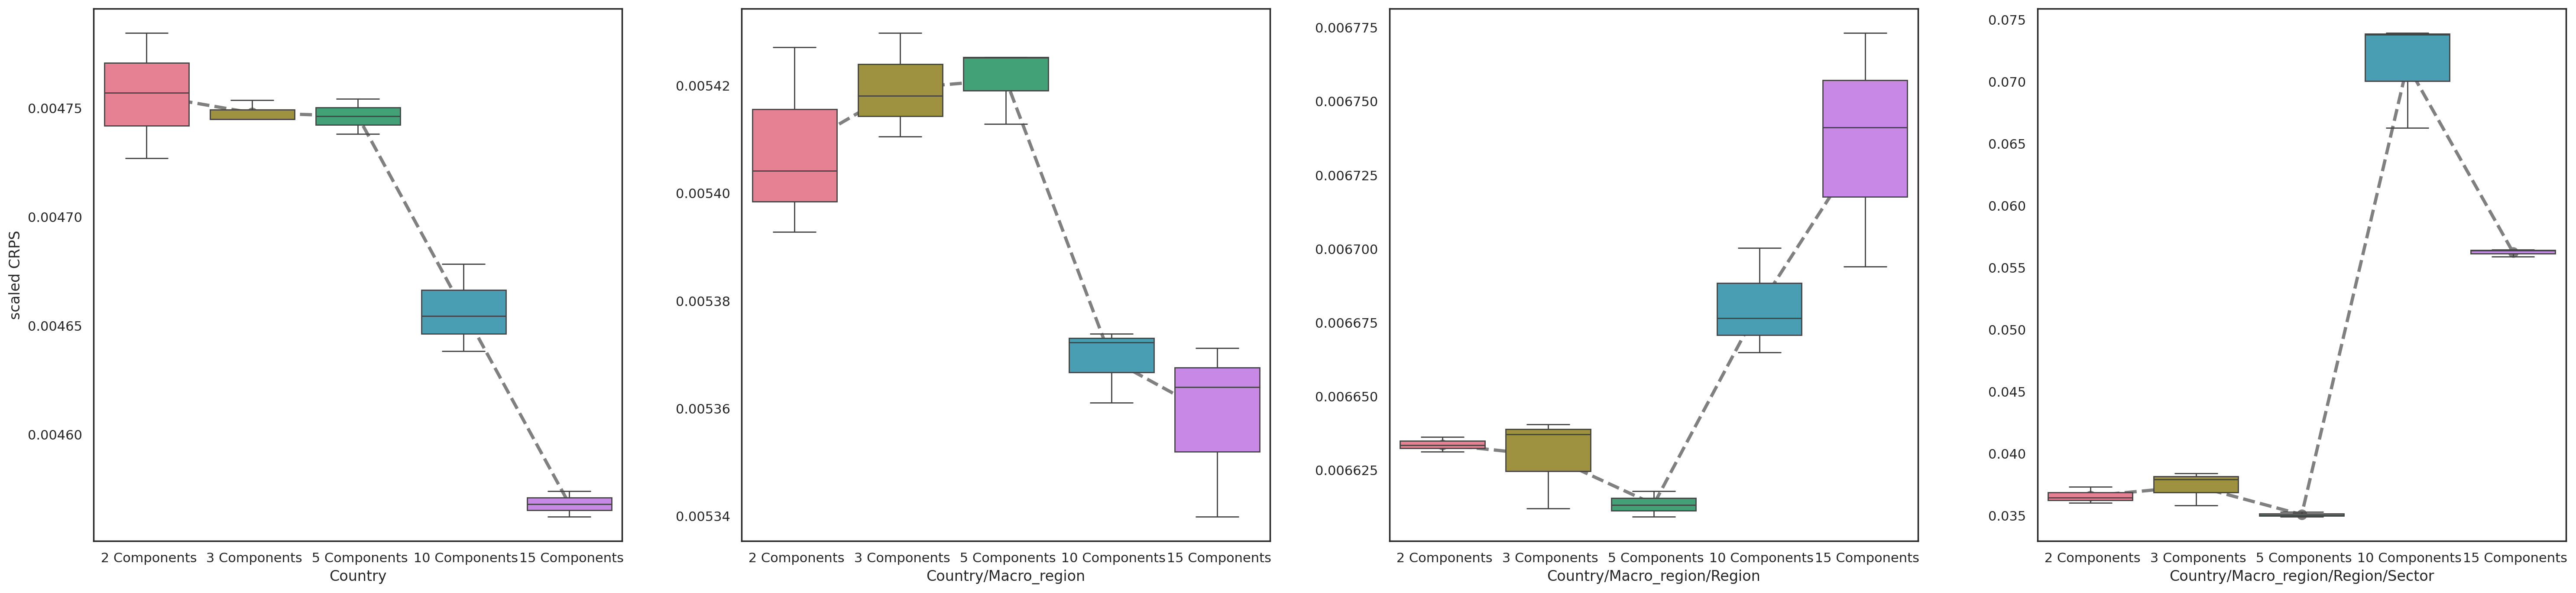

In [4]:
fig, axs = plt.subplots(1,4, figsize = (30,7), sharex = True, dpi = 200)
evv = eval_CLOVER.melt(id_vars = ['level', 'metric'])
evv['variable'] = evv['variable'].str[:-2]
T = evv.variable.unique()
for i,a in enumerate(T) :
    a = a.replace('CLOVER_NHITS_',' ')
    a = a.replace('_CRPS',' Components')
    T[i] = a
for k, level in zip(range(4),eval_CLOVER['level'].unique()):
    evs = evv.query(f'metric == "scaled_crps" & level == "{level}"')
    sns.pointplot(evs, y='value', x = 'variable', ax = axs[k], order = evs.variable.unique(), color = 'grey', errorbar = None, linestyle = '--')
    sns.boxplot(evs, y='value', x = 'variable', ax = axs[k], order = evs.variable.unique(), palette = 'husl')
    axs[k].set_ylabel(' ')
    # axs[k].set_ylim(-7,7)
    # axs[k].set_xlim(-.5,1.5)
    # axs[k].hlines(0, -1,5, linestyle = '--', color = 'black')
    axs[k].set_xlabel(f'{level}')
    axs[0].set_ylabel('scaled CRPS')
    axs[k].set_xticks(ticks = range(5), labels= T, rotation=0) 
plt.tight_layout()
plt.savefig('./n_components_CLOVER', dpi = 200, transparent = True)